## Panel dyskusyjny agentów

In [22]:
!pip install -q langgraph langchain langchain-openai python-dotenv


In [23]:
import os
from typing import TypedDict, List, Literal

from dotenv import load_dotenv
load_dotenv()

from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate


In [24]:
# Użyj stabilnego, przewidywalnego modelu do kontrolowanego przepływu
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)  # można zwiększyć kreatywność przez temperature>0
print("Model gotowy.")


Model gotowy.


### Stan grafu (State)

In [25]:
class PanelState(TypedDict):
    topic: str                      # temat dyskusji
    research_query: str             # aktualne zapytanie do "wyszukiwarki"
    research_context: str           # zebrane fakty / snippet'y
    transcript: List[str]           # przebieg rozmowy (teksty ról)
    proposal: str                   # propozycja/plan od eksperta
    decision: Literal["continue", "stop"]  # decyzja moderatora
    turn: int                       # licznik iteracji
    max_turns: int                  # limit, aby uniknąć nieskończonej pętli


### Lokalna „wyszukiwarka”

In [26]:
# Prosty lokalny korpus: (tytuł, treść)
CORPUS = [
    ("RAG basics", "RAG łączy retrieval kontekstu i generację odpowiedzi przez LLM."),
    ("LangGraph intro", "LangGraph to graf stanów: węzły (nodes), krawędzie (edges), pętle i warunki."),
    ("Prompting rules", "Jasne instrukcje, przykłady i formaty odpowiedzi podnoszą jakość wyników."),
    ("Vector stores", "FAISS to popularny wektorowy indeks do podobieństwa semantycznego."),
    ("Search APIs", "W produkcji możesz użyć np. Bing, Tavily lub własnego retrievera ze zbioru dokumentów."),
    ("Evaluation", "Krytyczna ewaluacja (critic) wykrywa luki i ryzyka w propozycji rozwiązania."),
]

def simple_search(query: str, k: int = 3) -> str:
    """Bardzo prosty 'retriever': filtruje po słowach kluczowych i zwraca top-k fragmentów."""
    tokens = set(t.lower() for t in query.split() if len(t) > 2)
    scored = []
    for title, text in CORPUS:
        score = sum(1 for t in tokens if t in (title.lower() + " " + text.lower()))
        scored.append((score, f"[{title}] {text}"))
    scored.sort(reverse=True, key=lambda x: x[0])
    results = [s for sc, s in scored[:k] if sc > 0]
    if not results:
        results = [f"[No exact hit] {title}: {text}" for title, text in CORPUS[:k]]
    return "\n• ".join(results)


### Prompty dla ról

In [27]:
researcher_prompt = ChatPromptTemplate.from_messages([
    ("system",
     "Jesteś Researcherem. Masz dostęp do fragmentów z 'wyszukiwarki' (RESEARCH).\n"
     "Twoim celem jest dostarczyć rzeczowe, krótkie fakty i dane wspierające temat.\n"
     "Odnoś się do fragmentów i nie fantazjuj. Pisz po polsku, zwięźle."),
    ("user",
     "TEMAT: {topic}\n"
     "DOTYCHCZASOWA DYSKUSJA:\n{transcript}\n\n"
     "RESEARCH (z wyszukiwarki):\n{research_context}\n\n"
     "Zadanie: Dodaj 3–6 faktów/obserwacji, najlepiej w punktach. Jeśli brakuje danych, "
     "zasugeruj precyzyjne kolejne zapytanie badawcze.\n"
     "Jeśli to możliwe, zaproponuj wstępną hipotezę.")
])

expert_prompt = ChatPromptTemplate.from_messages([
    ("system",
     "Jesteś Ekspertem. Z dostępnych faktów zaproponuj praktyczne rozwiązanie/plan.\n"
     "Uwzględnij kroki, wymagania i minimalny zestaw decyzji. Pisz po polsku, konkretnie."),
    ("user",
     "TEMAT: {topic}\n"
     "DOTYCHCZASOWA DYSKUSJA:\n{transcript}\n\n"
     "RESEARCH:\n{research_context}\n\n"
     "Zadanie: Zaproponuj plan działania w 3–7 krokach. Zaznacz założenia i ryzyka.")
])

critic_prompt = ChatPromptTemplate.from_messages([
    ("system",
     "Jesteś Krytykiem. Twoją rolą jest znaleźć luki, ryzyka i niejasności w propozycji.\n"
     "Zadawaj dociekliwe pytania i wskaż brakujące elementy. Bądź konstruktywny."),
    ("user",
     "TEMAT: {topic}\n"
     "DOTYCHCZASOWA DYSKUSJA:\n{transcript}\n\n"
     "RESEARCH:\n{research_context}\n\n"
     "PROPOZYCJA EKSPERTA:\n{proposal}\n\n"
     "Zadanie: Wypunktuj 3–6 najważniejszych braków/ryzyk i zaproponuj, co sprawdzić dalej.")
])

moderator_prompt = ChatPromptTemplate.from_messages([
    ("system",
     "Jesteś Moderatorem dyskusji. Decydujesz, czy kończymy, czy kontynuujemy.\n"
     "Jeśli kontynuujemy, podaj KRÓTKIE kolejne zapytanie badawcze (research_query) "
     "dla Researchera. Pisz po polsku. Jeżeli kończymy podsumuj dyskusję i przedstaw w utrukturyzowany i czytelny sposób odpowiedź na pytanie."),
    ("user",
     "TEMAT: {topic}\n"
     "DYSKUSJA:\n{transcript}\n\n"
     "RESEARCH:\n{research_context}\n\n"
     "PROPOZYCJA EKSPERTA:\n{proposal}\n\n"
     "KRYTYKA:\n{critic}\n\n"
     "Zadanie: Oceń jakość propozycji. Jeśli jest wystarczająca, odpowiedz dokładnie:\n"
     "DECISION: stop\n"
     "REASON: <krótki powód>\n\n"
     "Jeśli potrzebna jest dalsza praca, odpowiedz dokładnie:\n"
     "DECISION: continue\n"
     "RESEARCH_QUERY: <jedno zdanie zapytania>\n"
     "REASON: <krótki powód>")
])


### Węzły grafu (search, researcher, expert, critic, moderator, finish)

In [28]:
def node_search(state: PanelState) -> PanelState:
    """Tool node: obsługa 'wyszukiwarki' na podstawie research_query (lub tematu)."""
    query = state.get("research_query") or state["topic"]
    context = simple_search(query)
    new_transcript = state["transcript"] + [f"[Search] zapytanie: {query}\n• {context}"]
    return {
        "research_context": context,
        "transcript": new_transcript
    }

def node_researcher(state: PanelState) -> PanelState:
    """Researcher: streszcza i wnosi fakty. Może zasugerować nowe zapytanie."""
    resp = (researcher_prompt | llm).invoke({
        "topic": state["topic"],
        "transcript": "\n".join(state["transcript"]),
        "research_context": state["research_context"]
    })
    text = resp.content.strip()
    new_transcript = state["transcript"] + [f"[Researcher]\n{text}"]
    return {
        "transcript": new_transcript
    }

def node_expert(state: PanelState) -> PanelState:
    """Expert: proponuje plan/rozwiązanie."""
    resp = (expert_prompt | llm).invoke({
        "topic": state["topic"],
        "transcript": "\n".join(state["transcript"]),
        "research_context": state["research_context"]
    })
    proposal = resp.content.strip()
    new_transcript = state["transcript"] + [f"[Expert]\n{proposal}"]
    return {
        "proposal": proposal,
        "transcript": new_transcript
    }

def node_critic(state: PanelState) -> PanelState:
    """Critic: wskazuje luki i pytania."""
    resp = (critic_prompt | llm).invoke({
        "topic": state["topic"],
        "transcript": "\n".join(state["transcript"]),
        "research_context": state["research_context"],
        "proposal": state["proposal"]
    })
    critic_text = resp.content.strip()
    new_transcript = state["transcript"] + [f"[Critic]\n{critic_text}"]
    return {
        "transcript": new_transcript,
        "critic": critic_text  # ad-hoc pole; nie było w TypedDict — dodamy dynamicznie do stanu
    }

def parse_moderator_decision(text: str):
    decision = "continue"
    research_query = ""
    reason = ""
    for line in text.splitlines():
        l = line.strip()
        if l.upper().startswith("DECISION:"):
            val = l.split(":",1)[1].strip().lower()
            if val in ("stop","continue"):
                decision = val
        elif l.upper().startswith("RESEARCH_QUERY:"):
            research_query = l.split(":",1)[1].strip()
        elif l.upper().startswith("REASON:"):
            reason = l.split(":",1)[1].strip()
    return decision, research_query, reason

def node_moderator(state: PanelState) -> PanelState:
    """Moderator: decyduje o kontynuacji lub zakończeniu i (ewentualnie) ustala nowe zapytanie."""
    resp = (moderator_prompt | llm).invoke({
        "topic": state["topic"],
        "transcript": "\n".join(state["transcript"]),
        "research_context": state["research_context"],
        "proposal": state["proposal"],
        "critic": state.get("critic","(brak)")
    })
    text = resp.content.strip()
    decision, rq, reason = parse_moderator_decision(text)
    new_transcript = state["transcript"] + [f"[Moderator]\n{text}"]
    # Zwiększamy licznik tur:
    new_turn = state["turn"] + 1
    return {
        "decision": decision,
        "research_query": rq or state.get("research_query",""),
        "transcript": new_transcript,
        "turn": new_turn
    }

def node_finish(state: PanelState) -> PanelState:
    """Węzeł końcowy: wypisz krótkie podsumowanie."""
    print("=== PODSUMOWANIE ===")
    print("\n".join(state["transcript"]))  # drukujemy wszystkie wypowiedzi
    print("\nDecyzja końcowa:", state["decision"])
    print("Liczba tur:", state["turn"])
    return state


### Budowa grafu i warunków (conditional edge + loop + limit tur)

In [29]:
graph = StateGraph(PanelState)

graph.add_node("search", node_search)
graph.add_node("researcher", node_researcher)
graph.add_node("expert", node_expert)
graph.add_node("critic", node_critic)
graph.add_node("moderator", node_moderator)
graph.add_node("finish", node_finish)

# Wejście: zaczynamy od search
graph.set_entry_point("search")

# Główna ścieżka
graph.add_edge("search", "researcher")
graph.add_edge("researcher", "expert")
graph.add_edge("expert", "critic")
graph.add_edge("critic", "moderator")

# Warunek: moderator decyduje czy kończymy, czy wracamy do search
def route_after_moderator(state: PanelState):
    # Zabezpieczenie przed nieskończoną pętlą:
    if state["turn"] >= state["max_turns"]:
        return "finish"
    return "finish" if state["decision"] == "stop" else "search"

graph.add_conditional_edges("moderator", route_after_moderator, ["search", "finish"])
graph.add_edge("finish", END)

app = graph.compile()


### Uruchomienie scenariusza

In [30]:
initial_state: PanelState = {
    "topic": "Jak zbudować prosty system RAG w projekcie wewnętrznym?",
    "research_query": "LangGraph RAG basic steps vector store FAISS",
    "research_context": "",
    "transcript": [],
    "proposal": "",
    "decision": "continue",
    "turn": 0,
    "max_turns": 3,  # zmień jeśli chcesz dłuższej dyskusji
}

final_state = app.invoke(initial_state)


### Wizualizacja grafu

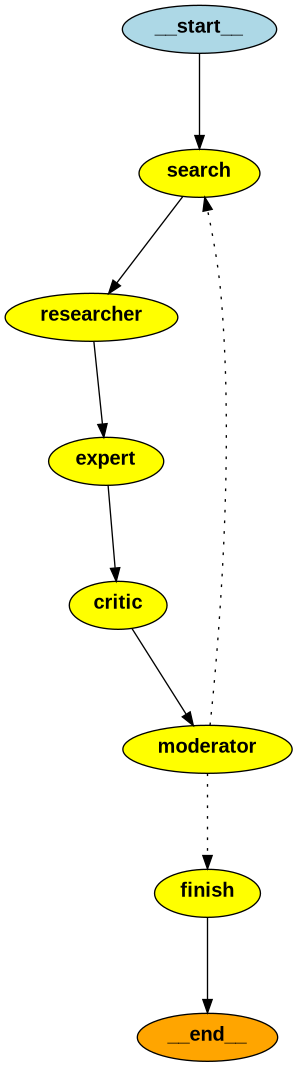

In [31]:
from IPython.display import Image, display

png_bytes = app.get_graph().draw_png()
display(Image(png_bytes))
